In [13]:
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# from Models import attention_unet as AttnUNet, vanilla_unet as UNet
from Models.attention_unet import AttnUNet
from Models.vanilla_unet import UNet


%matplotlib inline

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_mask_pairs = []
        self.transform = transform

        # Loop through all patient folders
        for patient_folder in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_folder)
            if not os.path.isdir(patient_path):
                continue

            # Collect image–mask pairs
            for file in os.listdir(patient_path):
                if file.endswith(".tif") and "_mask" not in file:
                    image_path = os.path.join(patient_path, file)
                    mask_path = image_path.replace(".tif", "_mask.tif")
                    if os.path.exists(mask_path):
                        self.image_mask_pairs.append((image_path, mask_path))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()  # Binary mask

        return image, mask

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

# print("Path to dataset files:", path)

In [18]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset_root = r"data/kaggle_3m"  # Update this path to your dataset location
dataset = BrainMRIDataset(root_dir=dataset_root, transform=transform)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
val_size=  0.2
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
train_idx, val_idx = indices[split: ], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(dataset, batch_size= 32 , sampler=train_sampler)
val_loader = DataLoader(dataset,batch_size=32 ,sampler=val_sampler)

images.shape =torch.Size([32, 3, 256, 256])


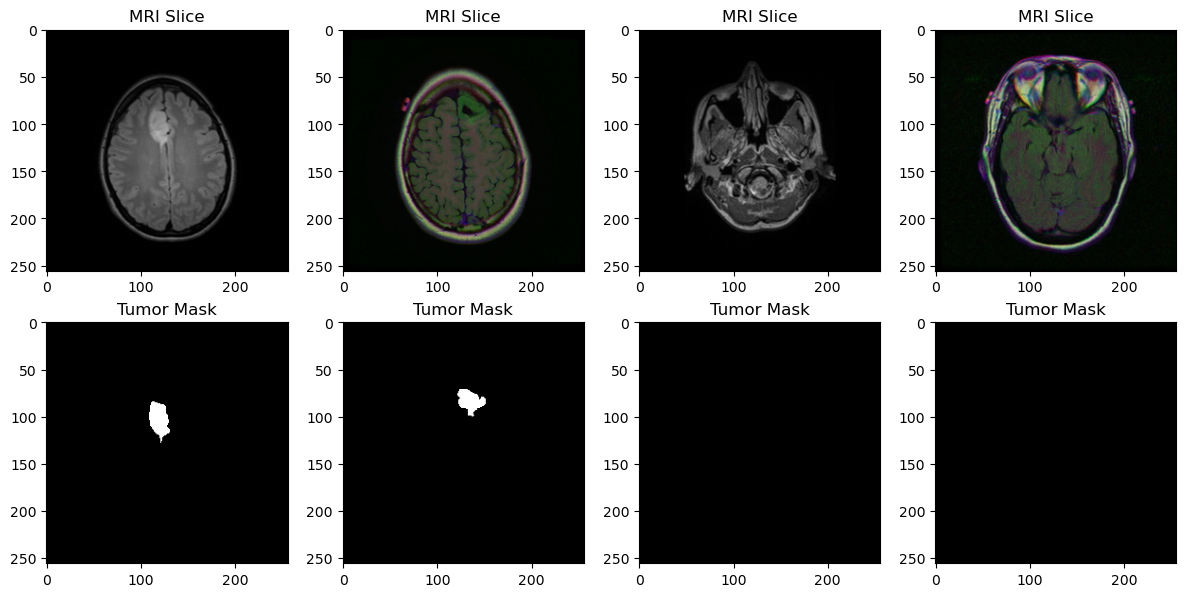

In [ ]:
# images, masks = next(iter(train_loader))
# print(F"{images.shape =}")
# plt.figure(figsize=(12, 6))
# for i in range(4):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(images[i].permute(1, 2, 0))
#     plt.title("MRI Slice")

#     plt.subplot(2, 4, i+5)
#     plt.imshow(masks[i][0], cmap='gray')
#     plt.title("Tumor Mask")

# plt.tight_layout()
# plt.show()

In [ ]:
# model = AttnUNet(input_channels=3, out_channels=1).to(device)
model = UNet(input_channels=3, out_channels=1).to(device)


lr= 3e-4
batch = 2
epochs = 10

In [20]:

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
crterion = nn.BCEWithLogitsLoss()

In [ ]:
# for epoch in range(epochs):
#     model.train()
#     runing_loss = 0
#     for idx , (image,mask) in enumerate(train_loader):
#         image = image.float().to(device)
#         mask = mask.float().to(device)
        
#         out = model(image)
#         optimizer.zero_grad()
#         loss = crterion(out, mask)
#         runing_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#     train_loss = runing_loss / idx + 1 
#     model.eval()
#     val_loss_runinig= 0
#     with torch.no_grad() :  # for fast compution
#         for idx , (image, mask) in enumerate(val_loader):
#             image = image.float().to(device)
#             mask = mask.float().to(device)
#             out = model(image)
#             loss =crterion(out, mask)
#             val_loss_runinig += loss.item()
#         val_loss = val_loss_runinig / idx + 1 
#         print(f"Epoch : {epoch + 1} ... Train Loss:{train_loss : .4f}....Val Loss: {val_loss:.4f}")
# torch.save(model.state_dict(), "UNet1.pth")

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.69 GiB is allocated by PyTorch, and 956.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [24]:
for epoch in range(epochs):
    model.train()
    runing_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for idx, (image, mask) in enumerate(train_loader_tqdm):
        image = image.float().to(device)
        mask = mask.float().to(device)
        
        out = model(image)
        optimizer.zero_grad()
        loss = crterion(out, mask)
        runing_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_loader_tqdm.set_postfix(loss=loss.item())
    train_loss = runing_loss / (idx + 1)
    model.eval()
    val_loss_runinig = 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for idx, (image, mask) in enumerate(val_loader_tqdm):
            image = image.float().to(device)
            mask = mask.float().to(device)
            out = model(image)
            loss = crterion(out, mask)
            val_loss_runinig += loss.item()
            val_loader_tqdm.set_postfix(loss=loss.item())
        val_loss = val_loss_runinig / (idx + 1)
        print(f"Epoch : {epoch + 1} ... Train Loss:{train_loss : .4f}....Val Loss: {val_loss:.4f}")
torch.save(model.state_dict(), "UNet1.pth")

encoder
torch.Size([32, 3, 256, 256])


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 12.92 GiB is allocated by PyTorch, and 1.36 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)